# Decision Tree Amazon Fine Food Reviews

In [15]:
%matplotlib inline

import sqlite3
import pandas as pd #for data frames
import numpy as np #numpy array operations
import nltk #natural lang processing, for processing text
import string
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from nltk.stem.porter import PorterStemmer
import pickle
import seaborn as sn

import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score,f1_score,precision_score,recall_score,auc,log_loss,confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.svm import SVC
from sklearn.manifold import TSNE

from scipy.stats import expon
import random

from sklearn.tree import DecisionTreeClassifier

In [16]:
pickle_in=open("cleanedData.pickle","rb")
final = pickle.load(pickle_in)

'''pickle_in = open("BOW_tfidf_avgW2V_TfidfW2V.pickle","rb")
count_vect = pickle.load(pickle_in) #BOW
final_counts = pickle.load(pickle_in) #BOW

tf_idf_vect = pickle.load(pickle_in) #TFIDF
final_tf_idf = pickle.load(pickle_in) #TFIDF
features = pickle.load(pickle_in) #TFIDF

w2v_model = pickle.load(pickle_in) #w2v
words = pickle.load(pickle_in) #w2v

sent_vectors = pickle.load(pickle_in) #avg W2V'''

import pickle
pickle_in = open("BOW_tfidf_avgW2V_Train_test_data.pickle","rb")

count_vect = pickle.load(pickle_in) #BOW
final_counts_train = pickle.load(pickle_in) #BOW
final_counts_test = pickle.load(pickle_in) #BOW
tf_idf_vect = pickle.load(pickle_in) #tfidf
final_tf_idf_train = pickle.load(pickle_in) #tfidf
final_tf_idf_test = pickle.load(pickle_in) #tfidf
features = pickle.load(pickle_in) 
sent_vectors_train = pickle.load(pickle_in) #avgW2v Vectors
sent_vectors_test = pickle.load(pickle_in) #avgW2v Vectors

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.19.1 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.1 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.1 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [17]:
train_data = final.head(int(0.80*final.shape[0]))
test_data = final.head(int(0.20*final.shape[0])+1)

scores = final['Score'].get_values()
len(scores)

364171

<h4>Util Functions</h4>

In [19]:
def convScores(scores):
    li = lambda x: 1 if x=='positive'  else 0
    final_scores = []
    for i in range(0,len(scores)):
        final_scores.append(li(scores[i]))
    return final_scores

def convToNpArray(arr):
    if(type(arr) == list):
        arr = np.array(arr)
        return arr
    else:
        return arr;
def confusionMatrix(y_test,pred):
    
    df_cm = pd.DataFrame(confusion_matrix(y_test, pred), index = ['False','True'],
                      columns = ['False','True'])
    sn.heatmap(df_cm, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.feature_importances_, feature_names))
    top = coefs_with_fns[:-(n + 1):-1]
    print("Top 10 Features:")
    for (coef_1, fn_1) in top:
        print("")
        print("%-15s" % (fn_1))

## Avg w2v DT

In [12]:
x_1 = sent_vectors_train[0:100000]


# this is only Score/rating  of data

y_1 = convScores(train_data['Score'].get_values())[0:100000]

x_test = sent_vectors_test[0:20000]
y_test = convScores(test_data['Score'].get_values())[0:20000]


x_1 = convToNpArray(x_1)
x_test = convToNpArray(x_test)
y_1 = convToNpArray(y_1)
y_test = convToNpArray(y_test)

In [13]:
tuned_parameters = {'max_depth':[11,21,41,61]}


DT_model = DecisionTreeClassifier(class_weight='balanced')
model = GridSearchCV(DT_model,tuned_parameters,
                     scoring='f1',cv=5,n_jobs=-1)

model.fit(x_1,y_1)

print(model.best_estimator_)
print("Score: ",model.score(x_test,y_test))

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=61, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Score:  0.911167653078


C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


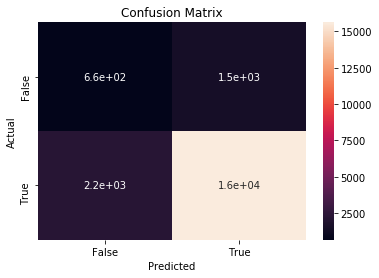

In [14]:
best_DT_model = model.best_estimator_
best_DT_model.fit(x_1,y_1)
pred = best_DT_model.predict(x_test)
confusionMatrix(y_test,pred)

In [7]:
def plotCVvsErr(li_of_depths,x_test,y_test):
    #li_of_depths = [5,7,9,11]
    li_of_errors=[]
    for i in li_of_depths:
        model = DecisionTreeClassifier(max_depth=i,class_weight='balanced')
        model.fit(x_1,y_1)
        err_val = 1-model.score(x_test,y_test);
        li_of_errors.append(err_val)

    plt.plot(li_of_depths,li_of_errors)
    plt.xlabel('Depths')
    plt.ylabel('Error Percentage')
    plt.show()

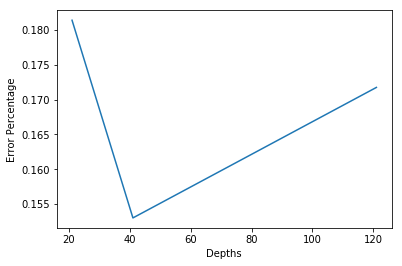

In [20]:
plotCVvsErr([21,41,121],x_test,y_test)

Observation: From the graph we can see that min Error is 0.1 at Depth 41, so best possible value of hyper parameter Depth is 41.

## BOW DT

In [13]:
x_1 = final_counts_train[0:10000]


# this is only Score/rating  of data

y_1 = convScores(train_data['Score'].get_values())[0:10000]

x_test = final_counts_test[0:3000]
y_test = convScores(test_data['Score'].get_values())[0:3000]

#x_1, x_test, y_1, y_test = train_test_split(x,y, test_size=0.3, random_state=0)

x_1 = convToNpArray(x_1)
x_test = convToNpArray(x_test)
y_1 = convToNpArray(y_1)
y_test = convToNpArray(y_test)

In [14]:
tuned_parameters = {'max_depth':[151,450,600,900]}


DT_model = DecisionTreeClassifier(class_weight='balanced')
model = GridSearchCV(DT_model,tuned_parameters,
                     scoring='f1',cv=5,n_jobs=-1)

model.fit(x_1,y_1)

print(model.best_estimator_)
print("Score: ",model.score(x_test,y_test))

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=900, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Score:  1.0


C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


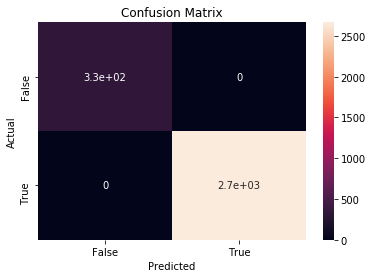

In [15]:
best_DT_model = model.best_estimator_
best_DT_model.fit(x_1,y_1)
pred = best_DT_model.predict(x_test)
confusionMatrix(y_test,pred)

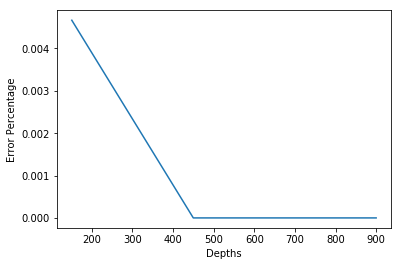

In [34]:
plotCVvsErr([151,450,600,900],x_test,y_test)

### Important Features

In [33]:
show_most_informative_features(count_vect,best_DT_model,10)

Top 10 Features:

great          

best           

love           

delici         

perfect        

use            

excel          

nice           

thought        

good           


## TFIDF DT

In [8]:
x_1 = final_tf_idf_train[0:10000]

y_1 = convScores(train_data['Score'].get_values())[0:10000]

x_test = final_tf_idf_test[0:3000]
y_test = convScores(test_data['Score'].get_values())[0:3000]

x_1 = convToNpArray(x_1)
x_test = convToNpArray(x_test)
y_1 = convToNpArray(y_1)
y_test = convToNpArray(y_test)

In [9]:
tuned_parameters = {'max_depth':[151,451,651]}


DT_model = DecisionTreeClassifier(class_weight='balanced')
model = GridSearchCV(DT_model,tuned_parameters,
                     scoring='f1',cv=5,n_jobs=-1)

model.fit(x_1,y_1)

print(model.best_estimator_)
print("Score: ",model.score(x_test,y_test))

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=451, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Score:  1.0


C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


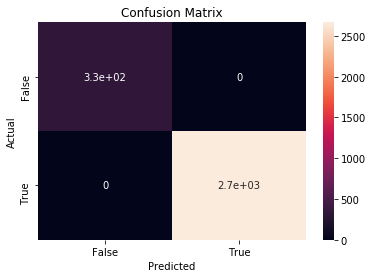

In [10]:
best_DT_model = model.best_estimator_
best_DT_model.fit(x_1,y_1)
pred = best_DT_model.predict(x_test)
confusionMatrix(y_test,pred)

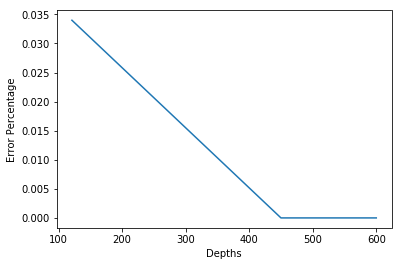

In [28]:
plotCVvsErr([121,450,600],x_test,y_test)

In [11]:
show_most_informative_features(tf_idf_vect,best_DT_model,10)

Top 10 Features:

great          

best           

love           

delici         

perfect        

good           

tea            

excel          

nice           

favorit        


## Important Features

Observation:

<table>
    <tr>
        <th>Vectorizer</th>
        <th>Depth(Hyper Parameter)</th>
        
    </tr>
    <tr>
        <td>Avg W2v</td>
        <td>41</td>
       
    </tr>
    <tr>
        <td>BOW</td>
        <td>450</td>
        
    </tr>
    <tr>
        <td>TfIdf</td>
        <td>450</td>
        
    </tr>
</table>